# Google Play Store Data

We will predit the rating of a Google Play Store app as a function of its attributes. We get our data from this source: https://www.kaggle.com/lava18/google-play-store-apps

Our first step will be to import all of the modules we need, and then load the data.

In [52]:
import Pkg
Pkg.add("CSV")
# Pkg.add("Plots")
Pkg.add("DataFrames")
Pkg.add("Statistics")
Pkg.add("StatsPlots")
Pkg.add("Measures")
Pkg.add("LowRankModels")
include("proxgrad.jl")
Pkg.add("Dates")

using Random
Random.seed!(13)

using CSV
# using Plots
using DataFrames
using StatsPlots
using Statistics
using LinearAlgebra
using Measures
using LowRankModels
using Dates

  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/

In [53]:
apps = CSV.read("googleplaystore.csv", pool=false)
names!(apps, Symbol.(replace.(string.(names(apps)), Ref(r"\s"=>"")))) #remove whitespace from column names
feature_names = names(apps)
for i in 1:13
    println(string(i), "\t", string(feature_names[i]), "\t\t\t", string(eltype(apps[!, i])))
end

thread = 1 warning: only found 12 / 13 columns around data row: 10474. Filling remaining columns with `missing`
thread = 1 warning: only found 12 / 13 columns around data row: 10474. Filling remaining columns with `missing`
1	App			String
2	Category			String
3	Rating			Float64
4	Reviews			String
5	Size			String
6	Installs			String
7	Type			String
8	Price			String
9	ContentRating			Union{Missing, String}
10	Genres			String
11	LastUpdated			String
12	CurrentVer			Union{Missing, String}
13	AndroidVer			Union{Missing, String}


In [54]:
apps

10841×13 DataFrame. Omitted printing of 12 columns
│ Row   │ App                                                │
│       │ String                                             │
├───────┼────────────────────────────────────────────────────┤
│ 1     │ Photo Editor & Candy Camera & Grid & ScrapBook     │
│ 2     │ Coloring book moana                                │
│ 3     │ U Launcher Lite – FREE Live Cool Themes, Hide Apps │
│ 4     │ Sketch - Draw & Paint                              │
│ 5     │ Pixel Draw - Number Art Coloring Book              │
│ 6     │ Paper flowers instructions                         │
│ 7     │ Smoke Effect Photo Maker - Smoke Editor            │
│ 8     │ Infinite Painter                                   │
│ 9     │ Garden Coloring Book                               │
│ 10    │ Kids Paint Free - Drawing Fun                      │
⋮
│ 10831 │ News Minecraft.fr                                  │
│ 10832 │ payermonstationnement.fr                           │
│ 10833 │ FR Tides                                           │
│ 10834 │ Chemin (fr)                                        │
│ 10835 │ FR Calculator                                      │
│ 10836 │ FR Forms                                           │
│ 10837 │ Sya9a Maroc - FR                                   │
│ 10838 │ Fr. Mike Schmitz Audio Teachings                   │
│ 10839 │ Parkinson Exercices FR                             │
│ 10840 │ The SCP Foundation DB fr nn5n                      │
│ 10841 │ iHoroscope - 2018 Daily Horoscope & Astrology      │

# (A) Clean Data

In [55]:
#Clean Ratings column 
num_missing=0
for idx=1:size(apps,1)
    if isnan(apps[idx, :Rating])
        num_missing+=1
    end
end 

not_missing_values = []
for idx=1:size(apps,1)
    if !isnan(apps[idx, :Rating])
        push!(not_missing_values, apps[idx, :Rating])
    end
end

mean_not_missing_values = mean(not_missing_values)

println("The mean of the unmissing values is $mean_not_missing_values")
println("We have $num_missing missing rating values")

new_ratings = Union{Missing,Float64}[]
for idx=1:size(apps,1)
    if isnan(apps[idx, :Rating])
        push!(new_ratings, missing)
    else
        push!(new_ratings, apps[idx, :Rating])
    end
end 

apps = select!(apps, Not(:Rating))
insert!(apps, 3, new_ratings, :Rating)
typeof(apps[:, :Rating])

The mean of the unmissing values is 4.193338315362443
We have 1474 missing rating values


Array{Union{Missing, Float64},1}

In [56]:
#Clean Size column

"This function converts strings to floating point values.
Strings that cannot be represented as a number (like NA) are converted to zeros"
function string_to_float(str)
    try
        parse(Float64, str)
    catch
       0.0
    end
end

missing_count = 0 
new_size = Union{Missing,Float64}[]
for idx=1:size(apps,1)
    if rstrip(apps[idx, :Size], 'M') != apps[idx, :Size]
        push!(new_size, string_to_float(rstrip(apps[idx, :Size], 'M')))
    elseif rstrip(apps[idx, :Size], 'k') != apps[idx, :Size]
        push!(new_size, round(string_to_float(rstrip(apps[idx, :Size], 'k'))/1000, digits=1))
    else
        missing_count += 1
        push!(new_size, missing)
    end
end

println("Varies with size count: ", missing_count)

apps = select!(apps, Not(:Size))
insert!(apps, 5, new_size, :Size)
typeof(apps[:, :Size])

Varies with size count: 1696


Array{Union{Missing, Float64},1}

In [57]:
#Clean Installs column

count = 0 
for idx=1:size(apps,1)
    if ismissing(apps[idx, :Installs])
        count += 1 
    end
end 

println(count) 


for idx=1:size(apps,1)
    apps[idx, :Installs] = replace(rstrip(apps[idx, :Installs], '+'), "," => "")
end

print(unique(apps[:, :Installs]))

0
["10000", "500000", "5000000", "50000000", "100000", "50000", "1000000", "10000000", "5000", "100000000", "1000000000", "1000", "500000000", "50", "100", "500", "10", "1", "5", "0", "Free"]

In [58]:
#Clean Type column

count = 0 
for idx=1:size(apps,1)
    if ismissing(apps[idx, :Type])
        count += 1 
    end
end 

println(count)

count = 0 
for idx=1:size(apps,1)
    if apps[idx, :Type] == "NaN"
        count += 1 
    end
end 

println(count)

count = 0 
for idx=1:size(apps,1)
    if apps[idx, :Type] == "0"
        count += 1 
    end
end 

println(count)

apps = filter(row -> !(row.Type in ["0", "NaN"]), apps);

typeof(apps[:, :Type])

0
1
1


Array{String,1}

In [59]:
print(size(apps))

(10839, 13)

In [60]:
#Clean Content Rating column 

count = 0 
for idx=1:size(apps,1)
    if ismissing(apps[idx, :ContentRating])
        count += 1 
    end
end 

println(count)

apps = dropmissing(apps, :ContentRating)

count = 0 
for idx=1:size(apps,1)
    if ismissing(apps[idx, :ContentRating])
        count += 1 
    end
end 

println(count)


count = 0 
new_content_ratings = String[]
for idx=1:size(apps,1)
    push!(new_content_ratings, apps[idx, :ContentRating])
end 

println(count)

apps = select!(apps, Not(:ContentRating))
insert!(apps, 9, new_content_ratings, :ContentRating)
typeof(apps[:, :ContentRating])

0
0
0


Array{String,1}

In [61]:
#Clean Category column 

count = 0 
for idx=1:size(apps,1)
    if ismissing(apps[idx, :Category])
        count += 1 
    end
end 

println(count)

count = 0 
for idx=1:size(apps,1)
    if apps[idx, :Category] == "1.9"
        count += 1 
    end
end 

print(count)

apps = filter(row -> !(row.Category in ["1.9"]), apps);

0
0

In [62]:
# Clean Price column 

count = 0 
for idx=1:size(apps,1)
    if ismissing(apps[idx, :Price])
        count += 1 
    end
end 

println(count)

price_float = Float64[]
for i=1:size(apps, 1)
    price = replace(apps[i, :Price], "\$" => "")
    push!(price_float, string_to_float(price))
end

apps = select!(apps, Not(:Price))
insert!(apps, 8, price_float, :Price)
typeof(apps[:, :Price])

0


Array{Float64,1}

In [63]:
# Transform last updated column 

apps = transform(apps, :LastUpdated => ByRow(x -> Dates.Date(x, "U d, y")) => :LastUpdated);
apps = transform(apps, :LastUpdated => ByRow(x -> Dates.datetime2rata(x)) => :LastUpdated);

In [64]:
apps[:, :LastUpdated];

# (B) Imputing Missing Values
First we need to one-hot-encode and many-hot-encode the categorical variables in order to fit a low rank model to the data and impute missing values. 

In [65]:
labels_real = [
    :Reviews,
    :Installs, 
]

vals_real = convert(Matrix, string_to_float.(apps[:, labels_real]))
vals_real = hcat(vals_real, apps[:, :Price])
vals_real = hcat(vals_real, apps[:, :LastUpdated])

#rating_vals = convert(Matrix, apps[:, :Rating])
#vals_real = hcat(vals_real, rating_vals)

10839×4 Array{Float64,2}:
    159.0   10000.0    0.0  736701.0
    967.0  500000.0    0.0  736709.0
  87510.0       5.0e6  0.0  736907.0
 215644.0       5.0e7  0.0  736853.0
    967.0  100000.0    0.0  736865.0
    167.0   50000.0    0.0  736414.0
    178.0   50000.0    0.0  736810.0
  36815.0       1.0e6  0.0  736859.0
  13791.0       1.0e6  0.0  736592.0
    121.0   10000.0    0.0  736878.0
  13880.0       1.0e6  0.0  736629.0
   8788.0       1.0e6  0.0  736906.0
  44829.0       1.0e7  0.0  736786.0
      ⋮                     
    603.0   10000.0    0.0  736134.0
    881.0  100000.0    0.0  735253.0
     38.0    5000.0    0.0  736858.0
   1195.0  100000.0    0.0  735280.0
     44.0    1000.0    0.0  735315.0
      7.0     500.0    0.0  736498.0
      0.0      10.0    0.0  736236.0
     38.0    5000.0    0.0  736535.0
      4.0     100.0    0.0  736881.0
      3.0    1000.0    0.0  736349.0
    114.0    1000.0    0.0  735617.0
 398307.0       1.0e7  0.0  736900.0

In [66]:
# Create one hot encoding for category-type columns 

cat_labels = [
    :Category,
    :Type,
    :ContentRating
]

#Sets of all categories in a particular column
cats_sets = [unique(apps[:, label]) for label in cat_labels]

3-element Array{Array{String,1},1}:
 ["ART_AND_DESIGN", "AUTO_AND_VEHICLES", "BEAUTY", "BOOKS_AND_REFERENCE", "BUSINESS", "COMICS", "COMMUNICATION", "DATING", "EDUCATION", "ENTERTAINMENT"  …  "SPORTS", "TRAVEL_AND_LOCAL", "TOOLS", "PERSONALIZATION", "PRODUCTIVITY", "PARENTING", "WEATHER", "VIDEO_PLAYERS", "NEWS_AND_MAGAZINES", "MAPS_AND_NAVIGATION"]
 ["Free", "Paid"]
 ["Everyone", "Teen", "Everyone 10+", "Mature 17+", "Adults only 18+", "Unrated"]

In [67]:
"Computes a onehot vector for every entry in column given a set of categories cats"
function onehot(column, cats=unique(column))
    n = size(column,1) 
    d = size(cats,1) 
    result = zeros(n, d)
    for i = 1:n 
        for j=1:d
            if ismissing(column[i])
                result[i,j]=0
            else
                if column[i] == cats[j] 
                    result[i, j] = 1
                end
            end 
        end
    end
    return result
end

onehot

In [68]:
cat_vals = hcat([onehot(apps[:, cat_labels[i]], cats_sets[i]) for i in 1:size(cat_labels, 1)]...); 

In [69]:
split_genres(x) = split(x, ";")

split_genres (generic function with 1 method)

In [70]:
genres = split_genres.(apps[:, :Genres])
genre_types = unique(vcat(genres...))

"Computes a manyhot vector for every entry in an array of arrays given a set of categories cats"
function manyhot(column, cats=unique(col))
    n = size(column, 1)
    d = size(cats, 1)
    result = zeros(n, d)
    
    for i = 1:n
        set_of_descriptions = column[i]
        for j = 1:d 
            if cats[j] in set_of_descriptions
                result[i, j] = 1 
            end
        end
    end 
    result
end

manyhot

In [71]:
genre_vals = manyhot(genres, genre_types);
allvals= hcat(genre_vals, cat_vals, vals_real)

10839×98 Array{Float64,2}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  …     159.0   10000.0    0.0  736701.0
 1.0  1.0  0.0  0.0  0.0  0.0  0.0        967.0  500000.0    0.0  736709.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0      87510.0       5.0e6  0.0  736907.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0     215644.0       5.0e7  0.0  736853.0
 1.0  0.0  1.0  0.0  0.0  0.0  0.0        967.0  100000.0    0.0  736865.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  …     167.0   50000.0    0.0  736414.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0        178.0   50000.0    0.0  736810.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0      36815.0       1.0e6  0.0  736859.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0      13791.0       1.0e6  0.0  736592.0
 1.0  0.0  1.0  0.0  0.0  0.0  0.0        121.0   10000.0    0.0  736878.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  …   13880.0       1.0e6  0.0  736629.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0       8788.0       1.0e6  0.0  736906.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0      44829.0       1.0e7  0.0  736786.

In [72]:
allvals=DataFrame(allvals)
insert!(allvals, 1, apps[:,:Size], :Size)
insert!(allvals, 2, apps[:,:Rating], :Rating)

10839×100 DataFrame. Omitted printing of 94 columns
│ Row   │ Size     │ Rating   │ x1      │ x2      │ x3      │ x4      │
│       │ Float64? │ Float64? │ Float64 │ Float64 │ Float64 │ Float64 │
├───────┼──────────┼──────────┼─────────┼─────────┼─────────┼─────────┤
│ 1     │ 19.0     │ 4.1      │ 1.0     │ 0.0     │ 0.0     │ 0.0     │
│ 2     │ 14.0     │ 3.9      │ 1.0     │ 1.0     │ 0.0     │ 0.0     │
│ 3     │ 8.7      │ 4.7      │ 1.0     │ 0.0     │ 0.0     │ 0.0     │
│ 4     │ 25.0     │ 4.5      │ 1.0     │ 0.0     │ 0.0     │ 0.0     │
│ 5     │ 2.8      │ 4.3      │ 1.0     │ 0.0     │ 1.0     │ 0.0     │
│ 6     │ 5.6      │ 4.4      │ 1.0     │ 0.0     │ 0.0     │ 0.0     │
│ 7     │ 19.0     │ 3.8      │ 1.0     │ 0.0     │ 0.0     │ 0.0     │
│ 8     │ 29.0     │ 4.1      │ 1.0     │ 0.0     │ 0.0     │ 0.0     │
│ 9     │ 33.0     │ 4.4      │ 1.0     │ 0.0     │ 0.0     │ 0.0     │
│ 10    │ 3.1      │ 4.7      │ 1.0     │ 0.0     │ 1.0     │ 0.0     │
⋮
│ 10829 │ 2.3      │ 3.8      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │
│ 10830 │ 9.8      │ missing  │ 0.0     │ 0.0     │ 0.0     │ 0.0     │
│ 10831 │ 0.6      │ 3.8      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │
│ 10832 │ 0.6      │ 4.8      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │
│ 10833 │ 2.6      │ 4.0      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │
│ 10834 │ 9.6      │ missing  │ 0.0     │ 0.0     │ 0.0     │ 0.0     │
│ 10835 │ 53.0     │ 4.5      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │
│ 10836 │ 3.6      │ 5.0      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │
│ 10837 │ 9.5      │ missing  │ 0.0     │ 0.0     │ 0.0     │ 0.0     │
│ 10838 │ missing  │ 4.5      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │
│ 10839 │ 19.0     │ 4.5      │ 0.0     │ 0.0     │ 0.0     │ 0.0     │

In [73]:
k=2

#Fit a general low rank model. This model uses QuadLoss loss for real valued columns, 
#HingeLoss loss for boolean columns, and ordinal HingeLoss loss for integer columns, 
#a small amount of QuadLoss regularization, and scaling and adding an offset to the model.

glrm, labels = GLRM(allvals, k)
X, Y, ch = fit!(glrm)

Fitting GLRM
Iteration 10: objective value = 5.958192967092987e7
Iteration 20: objective value = 2.75814051592878e7
Iteration 30: objective value = 2.7547113235340625e7


([0.5794459631312433 0.5863637623708753 … 0.5845798223770783 0.5822577906086904; 1.0 1.0 … 1.0 1.0], [1.0881209701552332 1.078886066970982 … 0.6039858196537057 1.4360025411108348; 1.8663945129190158 3.11065402890372 … -0.32367934807900506 -1.3838204866220514], ConvergenceHistory("ProxGradGLRM", [Inf, 3.235698656847334e9, 1.6655591111521413e9, 1.0892314317142606e9, 7.117316648624896e8, 4.5909790724887896e8, 2.850931030008717e8, 1.741029540281557e8, 1.1206071081449543e8, 7.466123696060488e7  …  2.757336222534246e7, 2.756976170980984e7, 2.7566421233452763e7, 2.7563058626030758e7, 2.7559695755978085e7, 2.7556378381681576e7, 2.7553070526799124e7, 2.7549925775171123e7, 2.7547113235340625e7, 2.7544844746646438e7], Float64[], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 2.544635057449341, 4.350302219390869, 6.057730197906494,

In [74]:
A = impute_missing(glrm)

10839×100 Array{Number,2}:
 19.0      4.1      1.0  0.0  0.0  …     159.0   10000.0    0.0  736701.0
 14.0      3.9      1.0  1.0  0.0        967.0  500000.0    0.0  736709.0
  8.7      4.7      1.0  0.0  0.0      87510.0       5.0e6  0.0  736907.0
 25.0      4.5      1.0  0.0  0.0     215644.0       5.0e7  0.0  736853.0
  2.8      4.3      1.0  0.0  1.0        967.0  100000.0    0.0  736865.0
  5.6      4.4      1.0  0.0  0.0  …     167.0   50000.0    0.0  736414.0
 19.0      3.8      1.0  0.0  0.0        178.0   50000.0    0.0  736810.0
 29.0      4.1      1.0  0.0  0.0      36815.0       1.0e6  0.0  736859.0
 33.0      4.4      1.0  0.0  0.0      13791.0       1.0e6  0.0  736592.0
  3.1      4.7      1.0  0.0  1.0        121.0   10000.0    0.0  736878.0
 28.0      4.4      1.0  0.0  0.0  …   13880.0       1.0e6  0.0  736629.0
 12.0      4.4      1.0  0.0  0.0       8788.0       1.0e6  0.0  736906.0
 20.0      4.2      1.0  0.0  0.0      44829.0       1.0e7  0.0  736786.0
  ⋮        

In [75]:
apps = select!(apps, Not(:Size))
insert!(apps, 1, A[:,1], :Size)
apps = select!(apps, Not(:Rating))
insert!(apps, 1, A[:,2], :Rating)

10839×13 DataFrame. Omitted printing of 11 columns
│ Row   │ Rating  │ Size    │
│       │ Number  │ Number  │
├───────┼─────────┼─────────┤
│ 1     │ 4.1     │ 19.0    │
│ 2     │ 3.9     │ 14.0    │
│ 3     │ 4.7     │ 8.7     │
│ 4     │ 4.5     │ 25.0    │
│ 5     │ 4.3     │ 2.8     │
│ 6     │ 4.4     │ 5.6     │
│ 7     │ 3.8     │ 19.0    │
│ 8     │ 4.1     │ 29.0    │
│ 9     │ 4.4     │ 33.0    │
│ 10    │ 4.7     │ 3.1     │
⋮
│ 10829 │ 3.8     │ 2.3     │
│ 10830 │ 3.72801 │ 9.8     │
│ 10831 │ 3.8     │ 0.6     │
│ 10832 │ 4.8     │ 0.6     │
│ 10833 │ 4.0     │ 2.6     │
│ 10834 │ 3.74517 │ 9.6     │
│ 10835 │ 4.5     │ 53.0    │
│ 10836 │ 5.0     │ 3.6     │
│ 10837 │ 3.72845 │ 9.5     │
│ 10838 │ 4.5     │ 2.50249 │
│ 10839 │ 4.5     │ 19.0    │

In [76]:
print(eltypes(apps))

Type[Number, Number, String, String, String, String, String, Float64, String, String, Int64, Union{Missing, String}, Union{Missing, String}]

In [77]:
print(names(apps))

["Rating", "Size", "App", "Category", "Reviews", "Installs", "Type", "Price", "ContentRating", "Genres", "LastUpdated", "CurrentVer", "AndroidVer"]

In [78]:
size_apps = convert(Array{Float64}, apps[:, :Size]);
print(typeof(size_apps))

apps = select!(apps, Not(:Size))
insert!(apps, 2, size_apps, :Size)
typeof(apps[:, :Size])

Array{Float64,1}

Array{Float64,1}

# (C) Train/Test Split

To make the 80 / 20 train test split, we are going to shuffle the data, and then select the first 80%
  as the train data, with 20%
  held out for validation.

In [242]:
feature_names = names(apps)

apps = apps[shuffle(1:end), :] # we shuffle the data so that our train/test split will be truly random

train_proportion = 0.8
n = size(apps, 1)
println("Size of dataset: ", string(n))

# Put the first ntrain observations in the DataFrame df into the training set, and the rest into the test set
ntrain = convert(Int, round(train_proportion*n))
ntest = n-ntrain

target = convert(Array{Float64}, apps[:, :Rating])
data = apps[:, filter(col -> (col != :Rating), feature_names)]

# the following variable records the features of examples in the training set
train_x = data[1:ntrain,:]
# the following variable records the features of examples in the test set
test_x = data[ntrain+1:n,:]
# the following variable records the labels of examples in the training set
train_y = target[1:ntrain,1]
# the following variable records the labels of examples in the test set
test_y = target[ntrain+1:n,1]

Size of dataset: 10839


2168-element Array{Float64,1}:
 3.7
 2.7
 4.2
 4.4
 4.3
 3.5
 4.1
 3.8
 4.3
 2.4
 4.1
 4.5
 4.4
 ⋮
 4.5
 4.5
 4.6
 4.3
 4.3
 4.5
 4.2
 4.4
 3.9
 5.0
 4.3
 3.7385870089133135

In [243]:
print(mean(train_y))

4.129490788988894

In [244]:
print(mean(test_y))

4.129653034699517

In [245]:
labels_real = [
    :Reviews,
    :Installs,
]

2-element Array{Symbol,1}:
 :Reviews
 :Installs

In [246]:
train_vals_real = convert(Matrix, string_to_float.(train_x[:, labels_real]))
test_vals_real = convert(Matrix, string_to_float.(test_x[:, labels_real]))

# Size, LastUpdated and Price do not have to be converted to float again
train_vals_real = hcat(train_vals_real, train_x[:, :Size])
test_vals_real = hcat(test_vals_real, test_x[:, :Size])

train_vals_real = hcat(train_vals_real, train_x[:, :LastUpdated])
test_vals_real = hcat(test_vals_real, test_x[:, :LastUpdated])

train_vals_real = hcat(train_vals_real, train_x[:, :Price])
test_vals_real = hcat(test_vals_real, test_x[:, :Price])

train_vals_real = hcat(train_vals_real, ones(ntrain, 1))
test_vals_real = hcat(test_vals_real, ones(ntest, 1))

2168×6 Array{Float64,2}:
  80847.0             5.0e7   2.49083  736893.0  0.0   1.0
     90.0          5000.0     4.0      736621.0  2.99  1.0
     36.0          1000.0     5.3      736308.0  0.0   1.0
   7731.0        100000.0    24.0      736908.0  0.0   1.0
    101.0         10000.0     3.9      736890.0  0.0   1.0
   1972.0             1.0e6  13.0      736826.0  0.0   1.0
  78298.0             5.0e6  29.0      736908.0  0.0   1.0
     67.0         10000.0     2.7      736121.0  0.0   1.0
   1311.0         10000.0    14.0      736886.0  0.0   1.0
    221.0         10000.0    43.0      736739.0  0.0   1.0
  45487.0             1.0e7   2.48924  736264.0  0.0   1.0
     14.0           100.0    45.0      736874.0  0.0   1.0
 138872.0             1.0e7  22.0      736829.0  0.0   1.0
      ⋮                                                ⋮
     61.0         10000.0     7.5      736788.0  0.0   1.0
   9548.0             1.0e6  15.0      736907.0  0.0   1.0
  36857.0             1.0e6  19.0

In [247]:
"""This function just computes the mean squared error."""
function MSE(y, pred)
    return mean((y .- pred) .^ 2)
end

MSE

In [248]:
"""This function just computes the mean squared error."""
function MAE(y, pred)
    return mean(abs.(y .- pred))
end

MAE

In [249]:
"""This function plots the main diagonal;
for a "predicted vs true" plot with perfect predictions,
all data lies on this line"""
function plotDiagonal(xmin, xmax)
    xsamples = [xmin, xmax]
    plot!(xsamples, xsamples, color=:black)
end

plotDiagonal

In [250]:
"""This helper funciton plots x vs, y and labels the axes."""
function plotdata(x,y,xname, yname, title; margin=0.05, plotDiag=true, zeromin=false)
    theme(:default)
    scatter(x,y, label="data", title=title, legend=:bottomright)
    xlabel!(xname)
    ylabel!(yname)
    range_y = maximum(y) - minimum(y)
    range_x = maximum(x) - minimum(x)
    if plotDiag
        plotDiagonal(minimum(x)-margin*range_x, maximum(x)+margin*range_x)
    end
#     if zeromin
#         ylims!((0.0,maximum(y)+margin*range_y))
#         xlims!((0.0,maximum(x)+margin*range_x))
#     else
#         ylims!((minimum(y)-margin*range_y,maximum(y)+margin*range_y))
#         xlims!((minimum(x)-margin*range_x,maximum(x)+margin*range_x))
#     end
end

plotdata

In [251]:
"""This function plots the predicted labels vs the actual labels
(We only plots the first 1000 points to avoid slow plots.)"""
function plot_pred_true(test_pred, test_y, title, max_points = 1000)
    plotdata(test_pred[1:max_points], test_y[1:max_points], "Predicted Rating", "True Rating", title, zeromin=true)
end

plot_pred_true

In [252]:
# The weights of your linear equation (compute via least squares)
w = train_vals_real \ train_y

#Your prediction vectors
train_pred = [sum(w.*train_vals_real[i, :]) for i=1:size(train_vals_real, 1)] 
test_pred = [sum(w.*test_vals_real[i, :]) for i=1:size(test_vals_real, 1)] 

total = 0 
overone = 0 
for i=1:length(train_pred)
    error = (train_pred[i] - train_y[i])^2
    total += error
    if error > 1
        overone += 1 
    end
end

# println(total)
# println(overone)

#The mean squared error for your predictions.
train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)

0.25278451316261946

In [253]:
print(length(train_pred))

8671

Train MSE	0.24519760452318204
Test MSE 	0.25278451316261946


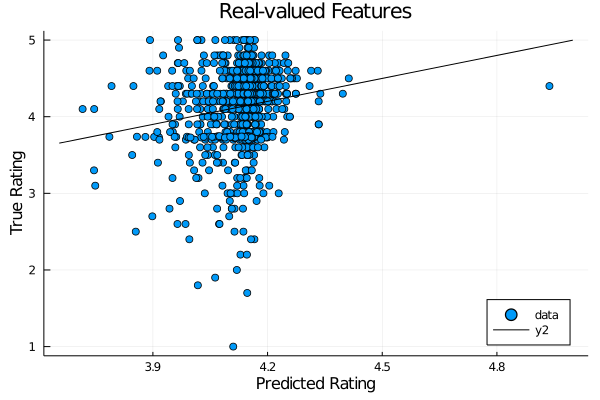

In [254]:
println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

# train_MAE = MAE(train_y, train_pred)
# test_MAE = MAE(test_y, test_pred)

# println("Train MSE\t", train_MAE)
# println("Test MSE \t", test_MAE)

plot_pred_true(test_pred, test_y, "Real-valued Features")

In [255]:
plot_pred_true(test_pred, test_y, "Real-Valued Features")
png("Real-Valued")

In [256]:
println(mean(test_pred))
println(minimum(test_pred))
println(maximum(test_pred))

4.130950647958882
3.6689230174828396
4.937424639347071


# (C) One-Hot Encoding

In [257]:
# Create one hot encoding for category-type columns 

cat_labels = [
    :Category,
    :Type,
    :ContentRating
]

#Sets of all categories in a particular column
cats_sets = [unique(train_x[:, label]) for label in cat_labels]

3-element Array{Array{String,1},1}:
 ["GAME", "MEDICAL", "FAMILY", "HOUSE_AND_HOME", "SHOPPING", "TOOLS", "LIBRARIES_AND_DEMO", "NEWS_AND_MAGAZINES", "SOCIAL", "HEALTH_AND_FITNESS"  …  "DATING", "AUTO_AND_VEHICLES", "BEAUTY", "EVENTS", "BOOKS_AND_REFERENCE", "ENTERTAINMENT", "EDUCATION", "PARENTING", "FOOD_AND_DRINK", "ART_AND_DESIGN"]
 ["Free", "Paid"]
 ["Everyone 10+", "Everyone", "Teen", "Mature 17+", "Unrated", "Adults only 18+"]

In [258]:
"Computes a onehot vector for every entry in column given a set of categories cats"
function onehot(column, cats=unique(column))
    n = size(column,1) 
    d = size(cats,1) 
    result = zeros(n, d)
    for i = 1:n 
        for j=1:d
            if column[i] == cats[j] 
                result[i, j] = 1
            end 
        end
    end
    return result
end

onehot

In [259]:
category_onehot = onehot(train_x[:, :Category], cats_sets[1])

8671×33 Array{Float64,2}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.

In [260]:
type_onehot = onehot(train_x[:, :Type], cats_sets[2])

8671×2 Array{Float64,2}:
 1.0  0.0
 1.0  0.0
 1.0  0.0
 1.0  0.0
 1.0  0.0
 1.0  0.0
 1.0  0.0
 1.0  0.0
 1.0  0.0
 1.0  0.0
 1.0  0.0
 0.0  1.0
 1.0  0.0
 ⋮    
 0.0  1.0
 1.0  0.0
 1.0  0.0
 1.0  0.0
 1.0  0.0
 1.0  0.0
 1.0  0.0
 1.0  0.0
 1.0  0.0
 1.0  0.0
 1.0  0.0
 0.0  1.0

In [261]:
content_rating_onehot = onehot(train_x[:, :ContentRating], cats_sets[3])

8671×6 Array{Float64,2}:
 1.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0

In [262]:
train_cat_vals = hcat([onehot(train_x[:, cat_labels[i]], cats_sets[i]) for i in 1:size(cat_labels, 1)]...)
test_cat_vals = hcat([onehot(test_x[:, cat_labels[i]], cats_sets[i]) for i in 1:size(cat_labels, 1)]...) 

2168×41 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.

In [263]:
train_vals = hcat(train_cat_vals, train_vals_real)
println(size(train_vals))
test_vals = hcat(test_cat_vals, test_vals_real)

w = train_vals \ train_y 

train_pred = [sum(w.*train_vals[i, :]) for i=1:size(train_vals, 1)] 
test_pred = [sum(w.*test_vals[i, :]) for i=1:size(test_vals, 1)] 

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)
        
println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

plot_pred_true(test_pred, test_y, "Real-Valued + One-hot Features")
png("OneHot")

(8671, 47)
Train MSE	0.23680624119328664
Test MSE 	0.2465539641700557


# (D) Many-Hot Encoding

In [264]:
print(train_x[1:100, :Genres])

["Action", "Medical", "Casual", "House & Home", "Medical", "Shopping", "Action", "Tools", "Libraries & Demo", "News & Magazines", "Social", "Health & Fitness", "Travel & Local", "Personalization", "Comics", "Business", "Travel & Local", "Action", "Medical", "Travel & Local", "Business", "Strategy;Education", "Tools", "Personalization", "Action", "Education", "Arcade", "Business", "Role Playing", "Lifestyle", "Shopping", "Finance", "Tools", "Health & Fitness", "Adventure", "Social", "Puzzle", "Productivity", "Business", "Personalization", "Communication", "Entertainment", "News & Magazines", "Entertainment", "Arcade", "Lifestyle", "Business", "Education", "Communication", "Racing", "Entertainment", "Education", "Tools", "Action", "Casual;Pretend Play", "Board;Brain Games", "Photography", "Sports", "Tools", "Personalization", "Weather", "Video Players & Editors", "News & Magazines", "Lifestyle", "Arcade", "Entertainment", "Education", "Action", "Health & Fitness", "Communication", "Puzzl

In [265]:
split_genres(x) = split(x, ";")
example_genres = split_genres(train_x[4, :Genres])

1-element Array{SubString{String},1}:
 "House & Home"

In [266]:
genres_train = split_genres.(train_x[:, :Genres])
genres_test = split_genres.(test_x[:, :Genres])

2168-element Array{Array{SubString{String},1},1}:
 ["Productivity"]
 ["Photography"]
 ["Personalization"]
 ["Finance"]
 ["Sports"]
 ["Dating"]
 ["Lifestyle"]
 ["Tools"]
 ["Education"]
 ["Health & Fitness"]
 ["Communication"]
 ["Action"]
 ["Tools"]
 ⋮
 ["Personalization"]
 ["News & Magazines"]
 ["House & Home"]
 ["Racing", "Action & Adventure"]
 ["Shopping"]
 ["Personalization"]
 ["Lifestyle"]
 ["Business"]
 ["Arcade"]
 ["Health & Fitness"]
 ["Entertainment"]
 ["Sports"]

In [267]:
genre_types = unique(vcat(genres_train...))

52-element Array{SubString{String},1}:
 "Action"
 "Medical"
 "Casual"
 "House & Home"
 "Shopping"
 "Tools"
 "Libraries & Demo"
 "News & Magazines"
 "Social"
 "Health & Fitness"
 "Travel & Local"
 "Personalization"
 "Comics"
 ⋮
 "Beauty"
 "Events"
 "Books & Reference"
 "Casino"
 "Parenting"
 "Music & Video"
 "Word"
 "Food & Drink"
 "Trivia"
 "Art & Design"
 "Creativity"
 "Music"

In [268]:
"Computes a manyhot vector for every entry in an array of arrays given a set of categories cats"
function manyhot(column, cats=unique(col))
    n = size(column, 1)
    d = size(cats, 1)
    result = zeros(n, d)
    
    for i = 1:n
        set_of_descriptions = column[i]
        for j = 1:d 
            if cats[j] in set_of_descriptions
                result[i, j] = 1 
            end
        end
    end 
    result
end

manyhot

In [269]:
genre_vals_train = manyhot(genres_train, genre_types)
genre_vals_test = manyhot(genres_test, genre_types)

two = 0 
for i=1:size(genre_vals_train, 1)
    total = sum(genre_vals_train[i, :])
    if total > 1
        two += 1
    end
end
println(two)
println(size(genre_vals_train, 1) - two)
println((size(genre_vals_train, 1) - two)/(two + size(genre_vals_train, 1)))

354
8317
0.9215512465373962


In [270]:
train_vals = hcat(genre_vals_train, train_vals)
test_vals = hcat(genre_vals_test, test_vals)

w = train_vals \ train_y

train_pred = [sum(w.*train_vals[i, :]) for i=1:size(train_vals, 1)] 
test_pred = [sum(w.*test_vals[i, :]) for i=1:size(test_vals, 1)] 

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)
    
println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

plot_pred_true(test_pred, test_y, "Real-Valued + One-Hot + Many-Hot Features")
png("ManyHot")

Train MSE	0.2345079700679518
Test MSE 	0.24439692576916103


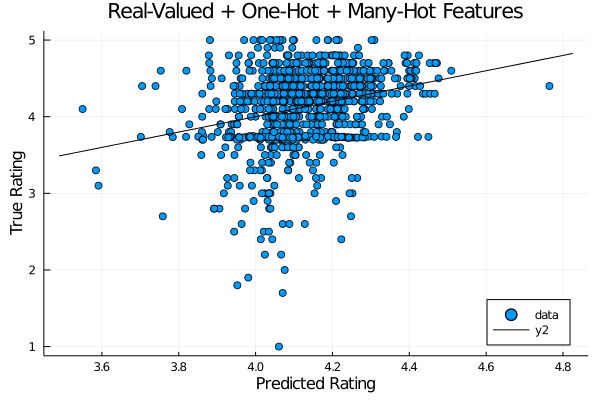

In [271]:
plot_pred_true(test_pred, test_y, "Real-Valued + One-Hot + Many-Hot Features")

In [272]:
println(mean(test_pred))
println(minimum(test_pred))
println(maximum(test_pred))

4.130877856239138
3.5225948677846617
4.846769229703895


In [672]:
train_bonus = hcat(train_x[:, :LastUpdated], genre_vals_train)
test_bonus = hcat(test_x[:, :LastUpdated], genre_vals_test)

train_bonus = hcat(train_bonus,  onehot(train_x[:, :Category], cats_sets[1]))
test_bonus = hcat(test_bonus,  onehot(test_x[:, :Category], cats_sets[1]))


# train_bonus = hcat(train_bonus, string_to_float.(train_x[:, :Installs]))
# test_bonus = hcat(test_bonus, string_to_float.(test_x[:, :Installs]))

# train_bonus = train_x[:, :LastUpdated] 
# test_bonus = test_x[:, :LastUpdated] 

train_bonus = hcat(train_bonus, ones(ntrain, 1))
test_bonus = hcat(test_bonus, ones(ntest, 1))

w = train_bonus \ train_y

train_pred = [sum(w.*train_bonus[i, :]) for i=1:size(train_bonus, 1)] 
test_pred = [sum(w.*test_bonus[i, :]) for i=1:size(test_bonus, 1)] 

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)
    
println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

plot_pred_true(test_pred, test_y, "LastUpdated + Genre + Category")
png("Bonus")

Train MSE	0.23798852751068125
Test MSE 	0.23809569695003044


In [673]:
println(mean(test_pred))
println(minimum(test_pred))
println(maximum(test_pred))

4.133987960669188
3.6033254705392324
4.599287637635143


In [674]:
trial_y = test_pred .- 0.5
test_MSE = MSE(test_y, trial_y)

0.4836936172903095

# (E) Data Exploration

### Ratings

In [675]:
println(mean(apps[:, :Rating]))
println(minimum(apps[:, :Rating]))
println(maximum(apps[:, :Rating]))
median(apps[:, :Rating])

4.129523241124758
1.0
5.0


4.2

In [676]:
theme(:sand)

@df apps density(:Rating, xlabel="App Rating", ylabel="Frequency", legend=false)
png("RatingDensity")

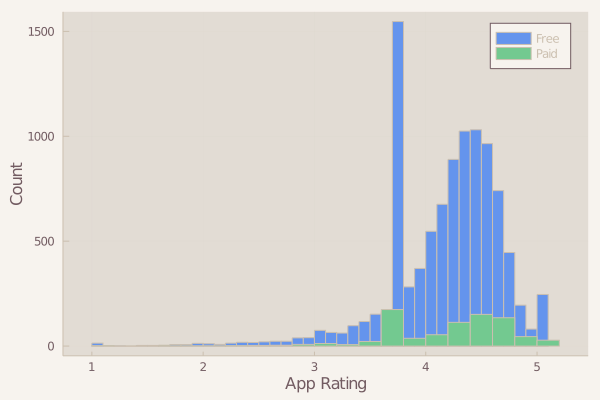

In [677]:
@df apps histogram(:Rating, group=:Type, xlabel="App Rating", ylabel="Count")

### Category

In [678]:
category_count = [] 
for idx=1:size(category_onehot,2)
    push!(category_count, sum(category_onehot[:, idx]))
end 
print(category_count)
print(minimum(category_count))

Any[180.0, 340.0, 207.0, 142.0, 659.0, 1543.0, 71.0, 56.0, 277.0, 907.0, 237.0, 123.0, 381.0, 313.0, 109.0, 371.0, 318.0, 314.0, 51.0, 261.0, 227.0, 307.0, 49.0, 68.0, 74.0, 46.0, 316.0, 118.0, 97.0, 74.0, 206.0, 193.0, 36.0]36.0

In [679]:
bar(category_count, xticks = (1:33, cats_sets[1]), xrotation=70, margin=10mm, legend=false, xlabel="Categories", ylabel="Count")
plot!(size=(700,600))
png("CategoryCount")


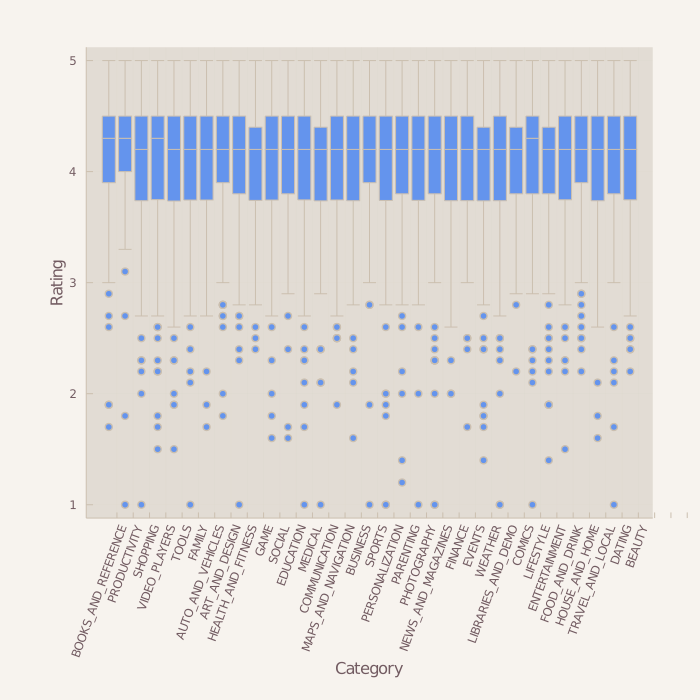

In [680]:

@df apps boxplot(cats_sets[1], :Rating, legend=false, xrotation=70, margin=10mm, xticks = (1:53, cats_sets[1]), 
    xlabel="Category", ylabel="Rating")
plot!(size=(700,700))

### Reviews

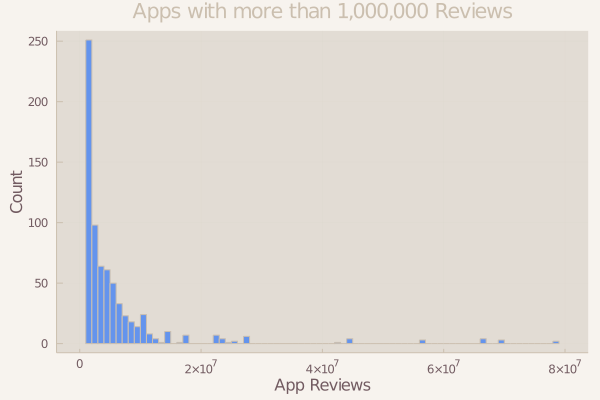

In [681]:
reviews_fl = transform(apps, :Reviews => ByRow(x -> string_to_float(x)) => :Reviews)
reviews_float = filter(row -> (row.Reviews > 1000000), reviews_fl); 
@df reviews_float histogram(:Reviews, xlabel="App Reviews", ylabel="Count", title="Apps with more than 1,000,000 Reviews", legend=false)

In [682]:
println(mean(reviews_fl[:, :Reviews]))
println(minimum(reviews_fl[:, :Reviews]))
println(maximum(reviews_fl[:, :Reviews]))
median(reviews_fl[:, :Reviews])

444193.87332779774
0.0
7.8158306e7


2094.0

In [683]:
using StatsBase
mode(reviews_fl[:, :Reviews])

0.0

In [684]:
mapslices(argmin,reviews_fl[:, :Reviews], dims=1)

1-element Array{Int64,1}:
 13

In [685]:
reviews_fl[5, :]

DataFrameRow. Omitted printing of 7 columns
│ Row │ Rating │ Size    │ App         │ Category │ Reviews │ Installs │
│     │ Number │ Float64 │ String      │ String   │ Float64 │ String   │
├─────┼────────┼─────────┼─────────────┼──────────┼─────────┼──────────┤
│ 5   │ 4.0    │ 4.6     │ Lock Screen │ TOOLS    │ 41137.0 │ 1000000  │

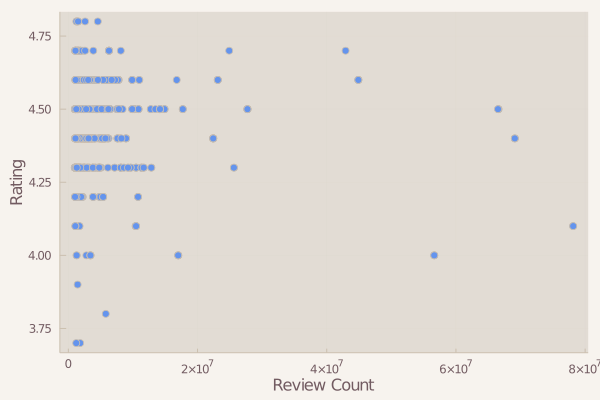

In [686]:
@df reviews_float scatter(:Reviews, :Rating, xlabel="Review Count", ylabel="Rating", legend=false)

### Size

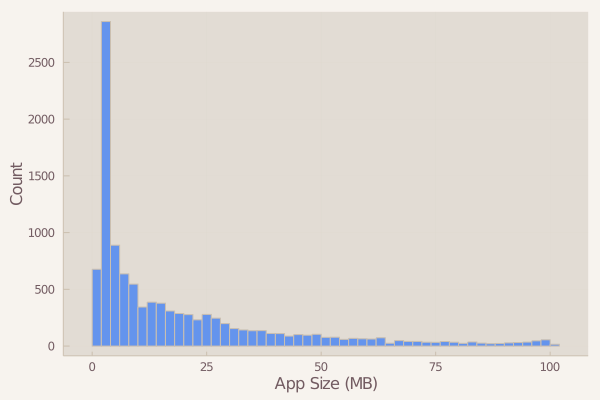

In [687]:
@df apps histogram(:Size, xlabel="App Size (MB)", ylabel="Count", legend=false)

In [688]:
println(mean(apps[:, :Size]))
println(minimum(apps[:, :Size]))
println(maximum(apps[:, :Size]))
median(apps[:, :Size])
mode(apps[:, :Size])

18.543723968222714
0.0
100.0


11.0

In [689]:
mapslices(argmin, apps[:, :Size], dims=1)

1-element Array{Int64,1}:
 66

In [690]:
apps[18, :]

DataFrameRow. Omitted printing of 7 columns
│ Row │ Rating │ Size    │ App                │ Category │ Reviews │ Installs │
│     │ Number │ Float64 │ String             │ String   │ String  │ String   │
├─────┼────────┼─────────┼────────────────────┼──────────┼─────────┼──────────┤
│ 18  │ 4.2    │ 23.0    │ Cook Baked Lasagna │ FAMILY   │ 56259   │ 10000000 │

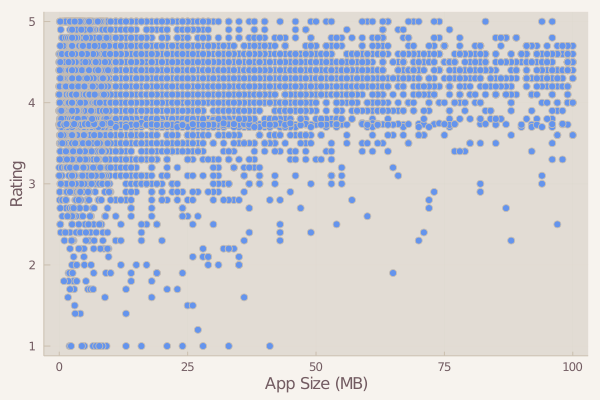

In [691]:
@df apps scatter(:Size, :Rating, xlabel="App Size (MB)", ylabel="Rating", legend=false)

### Type and Installs

In [692]:
type_count = [] 
for idx=1:size(type_onehot,2)
    push!(type_count, sum(type_onehot[:, idx]))
end 
print(type_count)
646/(8025.0+646)


Any[8029.0, 642.0]

0.07450121093299504

In [693]:
8025/(8025.0+646)

0.925498789067005

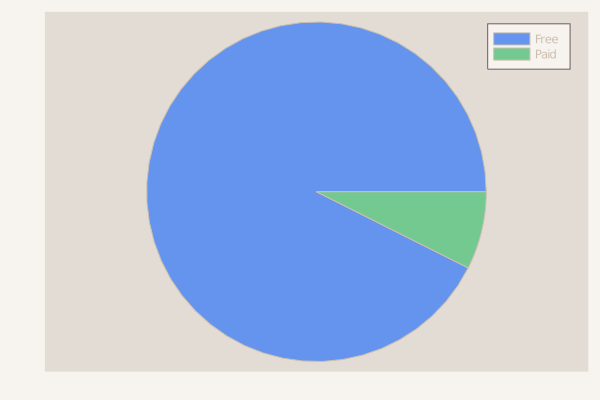

In [694]:
pie(cats_sets[2], type_count)

In [695]:
installs_fl = transform(apps, :Installs => ByRow(x -> string_to_float(x)) => :Installs)
# installs_float = filter(row -> !(row.Installs in [0]), installs_fl); # log(0) is undefined. 
# installs_log = transform(installs_float, :Installs => ByRow(x -> log(x)) => :Installs)
# @df installs_log boxplot(:Type, :Installs, group=:Type, legend=false, xlabel="Type", ylabel="Install Count (Log)")

In [696]:
println(mean(installs_fl[:, :Installs]))
println(minimum(installs_fl[:, :Installs]))
println(maximum(installs_fl[:, :Installs]))
mode(installs_fl[:, :Installs])

# # @df installs_fl density(:Installs)

1.5465765613709752e7
0.0
1.0e9


1.0e6

In [697]:
mapslices(argmin, installs_fl[:, :Installs], dims=1)

1-element Array{Int64,1}:
 13

In [698]:
installs_fl[103, :]

DataFrameRow. Omitted printing of 8 columns
│ Row │ Rating │ Size    │ App                        │ Category    │ Reviews │
│     │ Number │ Float64 │ String                     │ String      │ String  │
├─────┼────────┼─────────┼────────────────────────────┼─────────────┼─────────┤
│ 103 │ 4.6    │ 2.49766 │ Pic Collage - Photo Editor │ PHOTOGRAPHY │ 1451000 │

### Price

In [699]:
for i=1:size(apps, 1)
    
    if apps[i, :Type] == "Free"
        if apps[i, :Price] != 0
            println(apps[i, :Price])
        end
    end
    
    if apps[i, :Price] == 0
        if apps[i, :Type] != "Free"
            println(apps[i, :Type])
        end
    end
end

paid_apps = filter(row -> !(row.Type in ["Free"]), apps);
non_zero = filter(row -> !(row.Price in [0]), apps);

println("Count of paid apps: ", size(paid_apps))
println("Count of paid apps: ", size(non_zero))

price_float = Float64[]
for i=1:size(paid_apps, 1)
    price = paid_apps[i, :Price]
    push!(price_float, price)
end

Count of paid apps: (800, 13)
Count of paid apps: (800, 13)


In [700]:
println(minimum(paid_apps[:, :Price]))
println(maximum(paid_apps[:, :Price]))
println(mean(paid_apps[:, :Price]))

0.99
400.0
13.920837500000003


In [701]:
println(minimum(apps[:, :Price]))
println(maximum(apps[:, :Price]))
println(mean(apps[:, :Price]))

0.0
400.0
1.0274628655780056


In [702]:
mapslices(argmax, apps[:, :Price], dims=1)

1-element Array{Int64,1}:
 1816

In [703]:
apps[1082, :]

DataFrameRow. Omitted printing of 8 columns
│ Row  │ Rating │ Size    │ App          │ Category           │ Reviews │
│      │ Number │ Float64 │ String       │ String             │ String  │
├──────┼────────┼─────────┼──────────────┼────────────────────┼─────────┤
│ 1082 │ 4.8    │ 24.0    │ The Daily BJ │ HEALTH_AND_FITNESS │ 38      │

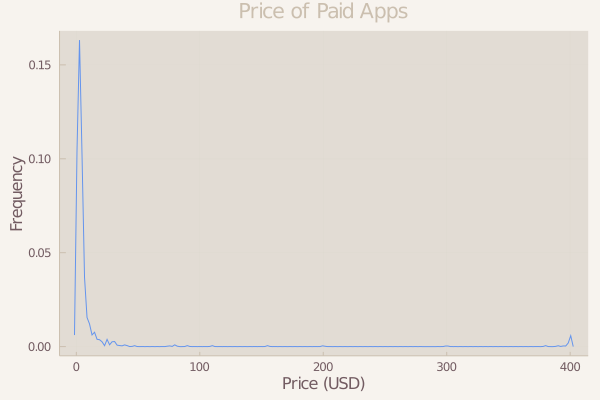

In [704]:
density(price_float, label=false, title="Price of Paid Apps", xlabel="Price (USD)", ylabel="Frequency")

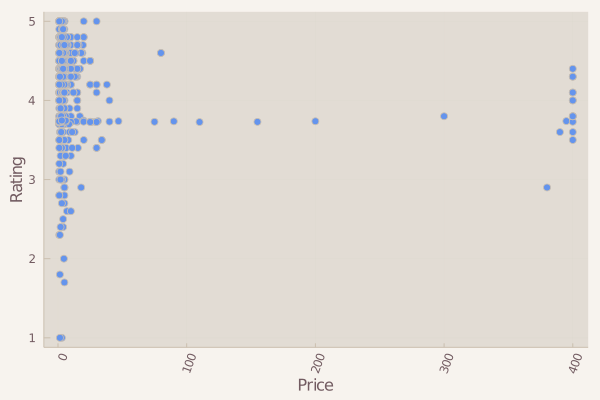

In [705]:
scatter(paid_apps[:, :Price], paid_apps[:, :Rating], xlabel="Price", ylabel="Rating", legend=false, xrotation=70)

### Content Rating

In [706]:
content_count = [] 
for idx=1:size(content_rating_onehot,2)
    push!(content_count, sum(content_rating_onehot[:, idx]))
end 

println(sum(content_count))
print(content_count)
print(content_count./sum(content_count))

8671.0
Any[6985.0, 329.0, 952.0, 400.0, 3.0, 2.0][0.8055587590819975, 0.037942567177949485, 0.10979125821704533, 0.04613078076346442, 0.00034598085572598315, 0.0002306539038173221]

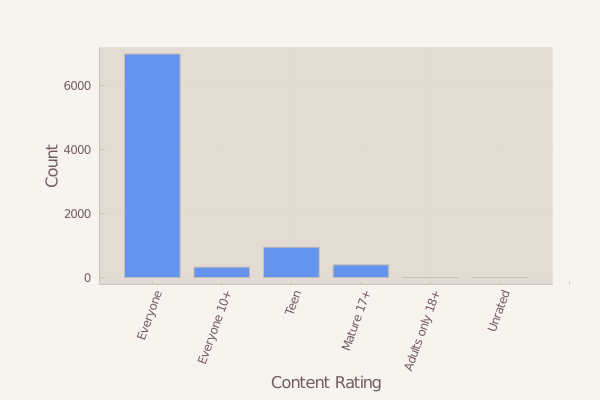

In [707]:
bar(content_count, xticks = (1:33, cats_sets[3]), xrotation=70, margin=10mm, legend=false, xlabel="Content Rating", ylabel="Count")
# plot!(size=(700,600))

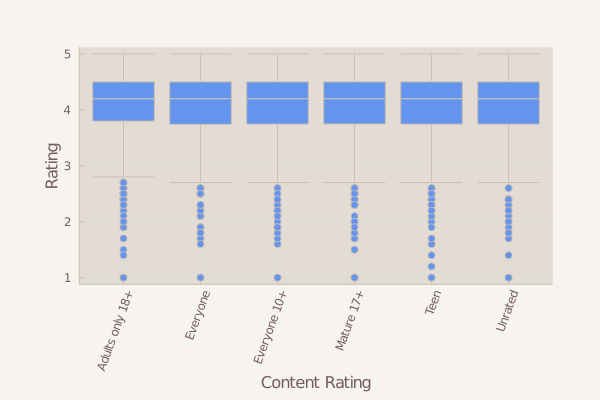

In [708]:
@df apps boxplot(cats_sets[3], :Rating, legend=false, xrotation=70, margin=10mm, 
    xlabel="Content Rating", ylabel="Rating")
# plot!(size=(700,700))

In [217]:
# Correlation between columns? Check for built in function. 
real_vals = transform(apps, :Installs => ByRow(x -> string_to_float(x)) => :Installs);
real_vals = transform(real_vals, :Reviews => ByRow(x -> string_to_float(x)) => :Reviews);
real_vals = transform(real_vals, :Rating => ByRow(x -> real(x)) => :Rating)

10839×13 DataFrame. Omitted printing of 11 columns
│ Row   │ Rating  │ Size    │
│       │ Float64 │ Float64 │
├───────┼─────────┼─────────┤
│ 1     │ 4.4     │ 3.4     │
│ 2     │ 5.0     │ 12.0    │
│ 3     │ 4.4     │ 26.0    │
│ 4     │ 3.9     │ 2.9     │
│ 5     │ 3.72699 │ 2.0     │
│ 6     │ 4.8     │ 2.0     │
│ 7     │ 4.5     │ 33.0    │
│ 8     │ 4.5     │ 5.1     │
│ 9     │ 4.9     │ 2.49263 │
│ 10    │ 4.8     │ 4.4     │
⋮
│ 10829 │ 4.1     │ 0.9     │
│ 10830 │ 3.8     │ 35.0    │
│ 10831 │ 3.5     │ 0.2     │
│ 10832 │ 3.72887 │ 13.0    │
│ 10833 │ 4.5     │ 2.49895 │
│ 10834 │ 4.7     │ 44.0    │
│ 10835 │ 4.9     │ 9.1     │
│ 10836 │ 3.9     │ 13.0    │
│ 10837 │ 3.73775 │ 5.5     │
│ 10838 │ 3.72701 │ 3.9     │
│ 10839 │ 4.8     │ 6.7     │

In [218]:
@df real_vals corrplot([:Rating :Size :Installs :Reviews :Price :LastUpdated], grid=false);

In [219]:
correlation = @df real_vals cor([:Rating :Reviews :Size :Installs :Price :LastUpdated])

6×6 Array{Float64,2}:
  1.0         0.0833684    0.0754824    0.0711273   -0.0224723    0.14278
  0.0833684   1.0          0.0727732    0.643121    -0.00966818   0.0852966
  0.0754824   0.0727732    1.0          0.00593759  -0.0145919    0.153833
  0.0711273   0.643121     0.00593759   1.0         -0.0116906    0.100924
 -0.0224723  -0.00966818  -0.0145919   -0.0116906    1.0         -0.00686084
  0.14278     0.0852966    0.153833     0.100924    -0.00686084   1.0

In [220]:
correlation_labels = correlation
for i=1:6
    for j=1:6
        correlation_labels[i, j] = round(correlation[i, j], digits=4)
    end
end

In [221]:
theme(:sand)
labels = ["Rating", "Reviews", "Size", "Installs", "Price", "LastUpdated"]
heatmap(labels, labels, correlation, yflip=true)
annotate!(vec(tuple.((1:length(labels))'.-0.5, (1:length(labels)).-0.5, string.(correlation_labels), 10)))
png("CorrelationPlot")
# annotate!(correlation)

# (F) Date Data

### Last Updated Column

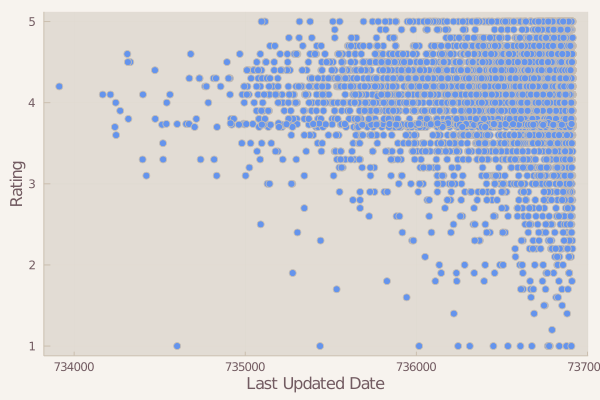

In [222]:
# Plot LastUpdated vs Rating
scatter(apps[:, :LastUpdated], apps[:, :Rating], xlabel="Last Updated Date", ylabel="Rating", legend=false)

In [606]:
println(Dates.rata2datetime(minimum(apps[:, :LastUpdated])))
println(Dates.rata2datetime(maximum(apps[:, :LastUpdated])))
print(Dates.rata2datetime(median(apps[:, :LastUpdated])))

2010-05-21T00:00:00
2018-08-08T00:00:00
2018-05-24T00:00:00

In [607]:
mapslices(argmin, apps[:, :LastUpdated], dims=1)

1-element Array{Int64,1}:
 2989

In [608]:
apps[2989, :]

DataFrameRow. Omitted printing of 8 columns
│ Row  │ Rating │ Size    │ App                       │ Category │ Reviews │
│      │ Number │ Float64 │ String                    │ String   │ String  │
├──────┼────────┼─────────┼───────────────────────────┼──────────┼─────────┤
│ 2989 │ 4.2    │ 0.2     │ FML F*ck my life + widget │ FAMILY   │ 1415    │

### User Reviews

In [224]:
reviews = CSV.read("googleplaystore_user_reviews.csv", pool=false)
names!(reviews, Symbol.(replace.(string.(names(reviews)), Ref(r"\s"=>"")))) #remove whitespace from column names
feature_names = names(reviews)
for i in 1:5
    println(string(i), "\t", string(feature_names[i]), "\t\t\t", string(eltype(apps[!, i])))
end

1	App			Number
2	Translated_Review			Float64
3	Sentiment			String
4	Sentiment_Polarity			String
5	Sentiment_Subjectivity			String


In [225]:
reviews

64295×5 DataFrame. Omitted printing of 4 columns
│ Row   │ App                         │
│       │ String                      │
├───────┼─────────────────────────────┤
│ 1     │ 10 Best Foods for You       │
│ 2     │ 10 Best Foods for You       │
│ 3     │ 10 Best Foods for You       │
│ 4     │ 10 Best Foods for You       │
│ 5     │ 10 Best Foods for You       │
│ 6     │ 10 Best Foods for You       │
│ 7     │ 10 Best Foods for You       │
│ 8     │ 10 Best Foods for You       │
│ 9     │ 10 Best Foods for You       │
│ 10    │ 10 Best Foods for You       │
⋮
│ 64285 │ Houzz Interior Design Ideas │
│ 64286 │ Houzz Interior Design Ideas │
│ 64287 │ Houzz Interior Design Ideas │
│ 64288 │ Houzz Interior Design Ideas │
│ 64289 │ Houzz Interior Design Ideas │
│ 64290 │ Houzz Interior Design Ideas │
│ 64291 │ Houzz Interior Design Ideas │
│ 64292 │ Houzz Interior Design Ideas │
│ 64293 │ Houzz Interior Design Ideas │
│ 64294 │ Houzz Interior Design Ideas │
│ 64295 │ Houzz Interior Design Ideas │

In [226]:
# reviews = filter(row -> !(row.Translated_Review ), reviews)

In [227]:
print("Number of apps with reviews: ", length(unique(reviews[:, :App])))

Number of apps with reviews: 1074

In [228]:
unique_apps = unique(apps[:, :App]);

In [229]:
unique_revs = unique(reviews[:, :App]);

In [230]:
match_reviews = filter(row -> (row.App in unique_apps), reviews)
print(length(unique(match_reviews[:, :App])))

1020

# (G) Feature Modeling

Let's compare predict rating with each feature individually to see which has the lowest error and explore that feature more closely.

### Category

In [ ]:
train_vals_cat = hcat(onehot(train_x[:, :Category], cats_sets[1]), ones(ntrain, 1))
test_vals_cat = hcat(onehot(test_x[:, :Category], cats_sets[1]), ones(ntest, 1))

w = train_vals_cat \ train_y

train_pred_cat = [sum(w.*train_vals_cat[i, :]) for i=1:size(train_vals_cat, 1)] 
test_pred_cat = [sum(w.*test_vals_cat[i, :]) for i=1:size(test_vals_cat, 1)] 

train_MSE_cat = MSE(train_y, train_pred_cat)
test_MSE_cat = MSE(test_y, test_pred_cat)
    
println("Train MSE\t", train_MSE_cat)
println("Test MSE \t", test_MSE_cat)

### Reviews

In [ ]:
train_vals_rev = hcat((train_vals_real[:, 1] .^ 2), ones(ntrain, 1))
test_vals_rev = hcat((test_vals_real[:, 1] .^ 2), ones(ntest, 1))

w = train_vals_rev \ train_y

train_pred_rev = [sum(w.*train_vals_rev[i, :]) for i=1:size(train_vals_rev, 1)] 
test_pred_rev = [sum(w.*test_vals_rev[i, :]) for i=1:size(test_vals_rev, 1)] 

train_MSE_rev = MSE(train_y, train_pred_rev)
test_MSE_rev = MSE(test_y, test_pred_rev)
    
println("Train MSE\t", train_MSE_rev)
println("Test MSE \t", test_MSE_rev)

### Size

In [ ]:
train_vals_size = hcat((train_vals_real[:, 2] .^3), ones(ntrain, 1))
test_vals_size = hcat((test_vals_real[:, 2] .^3), ones(ntest, 1))

w = train_vals_size \ train_y

train_pred_size = [sum(w.*train_vals_size[i, :]) for i=1:size(train_vals_size, 1)] 
test_pred_size = [sum(w.*test_vals_size[i, :]) for i=1:size(test_vals_size, 1)] 

train_MSE_size = MSE(train_y, train_pred_size)
test_MSE_size = MSE(test_y, test_pred_size)
    
println("Train MSE\t", train_MSE_size)
println("Test MSE \t", test_MSE_size)

### Installs

In [ ]:
train_vals_installs = hcat((train_vals_real[:, 3].^2), ones(ntrain, 1))
test_vals_installs = hcat((test_vals_real[:, 3].^2), ones(ntest, 1))

w = train_vals_installs \ train_y

train_pred_installs = [sum(w.*train_vals_installs[i, :]) for i=1:size(train_vals_installs, 1)] 
test_pred_installs = [sum(w.*test_vals_installs[i, :]) for i=1:size(test_vals_installs, 1)] 

train_MSE_installs = MSE(train_y, train_pred_installs)
test_MSE_installs = MSE(test_y, test_pred_installs)
    
println("Train MSE\t", train_MSE_installs)
println("Test MSE \t", test_MSE_installs)

### Type

In [ ]:
train_vals_type = hcat(onehot(train_x[:, :Type], cats_sets[2]), ones(ntrain, 1))
test_vals_type = hcat(onehot(test_x[:, :Type], cats_sets[2]), ones(ntest, 1))

w = train_vals_type \ train_y

train_pred_type = [sum(w.*train_vals_type[i, :]) for i=1:size(train_vals_type, 1)] 
test_pred_type = [sum(w.*test_vals_type[i, :]) for i=1:size(test_vals_type, 1)] 

train_MSE_type = MSE(train_y, train_pred_type)
test_MSE_type = MSE(test_y, test_pred_type)
    
println("Train MSE\t", train_MSE_type)
println("Test MSE \t", test_MSE_type)

### Price

In [ ]:
train_vals_price = hcat((train_x[:, :Price]), ones(ntrain, 1))
test_vals_price = hcat((test_x[:, :Price]), ones(ntest, 1))

w = train_vals \ train_y

train_pred = [sum(w.*train_vals[i, :]) for i=1:size(train_vals, 1)] 
test_pred = [sum(w.*test_vals[i, :]) for i=1:size(test_vals, 1)] 

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)
    
println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

### Content Rating

In [ ]:
train_vals_cr = hcat(onehot(train_x[:, :ContentRating], cats_sets[3]), ones(ntrain, 1))
test_vals_cr = hcat(onehot(test_x[:, :ContentRating], cats_sets[3]), ones(ntest, 1))

w = train_vals_cr \ train_y

train_pred_cr = [sum(w.*train_vals_cr[i, :]) for i=1:size(train_vals_cr, 1)] 
test_pred_cr = [sum(w.*test_vals_cr[i, :]) for i=1:size(test_vals_cr, 1)] 

train_MSE_cr = MSE(train_y, train_pred_cr)
test_MSE_cr = MSE(test_y, test_pred_cr)
    
println("Train MSE\t", train_MSE_cr)
println("Test MSE \t", test_MSE_cr)

### Genres

In [ ]:
train_vals_genre = hcat(genre_vals_train, ones(ntrain, 1))
test_vals_genre = hcat(genre_vals_test, ones(ntest, 1))

w = train_vals_genre \ train_y

train_pred_genre = [sum(w.*train_vals_genre[i, :]) for i=1:size(train_vals_genre, 1)] 
test_pred_genre = [sum(w.*test_vals_genre[i, :]) for i=1:size(test_vals_genre, 1)] 

train_MSE_genre = MSE(train_y, train_pred_genre)
test_MSE_genre = MSE(test_y, test_pred_genre)
    
println("Train MSE\t", train_MSE_genre)
println("Test MSE \t", test_MSE_genre)

### Last Updated

In [ ]:
train_vals_update = hcat((train_x[:, :LastUpdated] .^1), ones(ntrain, 1))
test_vals_update = hcat((test_x[:, :LastUpdated].^1), ones(ntest, 1))

w = train_vals_update \ train_y

train_pred_update = [sum(w.*train_vals_update[i, :]) for i=1:size(train_vals_update, 1)] 
test_pred_update = [sum(w.*test_vals_update[i, :]) for i=1:size(test_vals_update, 1)] 

train_MSE_update = MSE(train_y, train_pred_update)
test_MSE_update = MSE(test_y, test_pred_update)
    
println("Train MSE\t", train_MSE_update)
println("Test MSE \t", test_MSE_update)

plot_pred_true(test_pred_update, test_y, "Last Updated")

# (H) Regularized Linear Models

### L1 Loss

In [ ]:
loss = 1/ntrain * L1Loss()
λ = 0.1
reg = λ * OneReg()
w_l1 = proxgrad(loss, reg, train_vals_update, train_y, maxiters=100)

train_pred = train_vals_update*w_l1
test_pred = test_vals_update*w_l1

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)

println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

plot_pred_true(test_pred, test_y, "L1 Loss + OneReg")

In [ ]:
println("Min predicted rating: ", minimum(test_pred))
println("Max predicted rating: ", maximum(test_pred))

**Note:** Our predicted ratings are in the range 0-9, we need to limit this to 1-5. Let's try other regularizers to see if that helps.

In [ ]:
loss = 1/ntrain * L1Loss()
λ = 0.1
reg =  λ * QuadReg()
w_l1 = proxgrad(loss, reg, train_vals, train_y, maxiters=100) 

train_pred = train_vals*w_l1
test_pred = test_vals*w_l1

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)

println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

plot_pred_true(test_pred, test_y, "L1 Loss + QuadReg")

**Note:** Let's experiment using features individually and some combinations.

In [ ]:
features_train = [train_vals_cat, train_vals_rev, train_vals_size, train_vals_installs, train_vals_type, train_vals_cr, 
    train_vals_genre, train_vals_update]

features_test = [test_vals_cat, test_vals_rev, test_vals_size, test_vals_installs, test_vals_type, test_vals_cr, 
    test_vals_genre, test_vals_update]

features = ["Category", "Reviews", "Size", "Installs", "Type", "ContentRating", "Genre", "LastUpdate"]

for i=1:length(features_train)
    
    println(features[i])
    
    loss = 1/ntrain * L1Loss()
    λ = 0.1
    reg = λ * OneReg()
    w_l1 = proxgrad(loss, reg, features_train[i], train_y, maxiters=100)

    train_pred = features_train[i]*w_l1
    test_pred = features_test[i]*w_l1

    train_MSE = MSE(train_y, train_pred)
    test_MSE = MSE(test_y, test_pred)

    println("Train MSE\t", train_MSE)
    println("Test MSE \t", test_MSE)
    
    println("Min predicted rating: ", minimum(test_pred))
    println("Max predicted rating: ", maximum(test_pred))

#     train_MAE = mean_absolute_error(train_y, train_pred)
#     test_MAE = mean_absolute_error(test_y, test_pred)
    
#     println("Train MAE\t", train_MAE)
#     println("Test MAE \t", test_MAE)
    print("\n")
       
end


In [ ]:
loss = 1/ntrain * L1Loss()
λ = 0.1
reg =  λ * QuadReg()

train_vals_rev_update = hcat(train_vals_rev, train_vals_update)
test_vals_rev_update = hcat(test_vals_rev, test_vals_update)

w_l1 = proxgrad(loss, reg, train_vals_rev_update, train_y, maxiters=100) 

train_pred = train_vals_rev_update*w_l1
test_pred = test_vals_rev_update*w_l1

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)

println("Min predicted rating: ", minimum(test_pred))
println("Max predicted rating: ", maximum(test_pred))

println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

plot_pred_true(test_pred, test_y, "L1 Loss + QuadReg")

# (I) Other Sklearn Models

In [231]:
Pkg.add("ScikitLearn")
using ScikitLearn
@sk_import linear_model: (Ridge, Lasso, ElasticNet)
@sk_import metrics: mean_absolute_error
@sk_import svm: SVR
@sk_import ensemble: RandomForestRegressor
@sk_import neural_network: MLPRegressor
@sk_import tree: (plot_tree, DecisionTreeRegressor)
@sk_import feature_selection: (SelectFromModel, VarianceThreshold)

  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`


PyObject <class 'sklearn.feature_selection._variance_threshold.VarianceThreshold'>

Train MSE	0.23061995115008824
Test MSE 	0.2600792636535021

Train MAE	0.35679620929586375
Test MAE 	0.37294738236056324


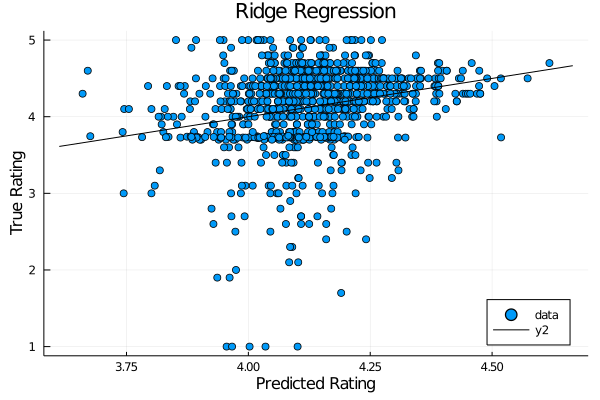

In [232]:
ridge = Ridge()
ridge.fit(train_vals, train_y)

train_pred = ridge.predict(train_vals);
test_pred = ridge.predict(test_vals);

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)

println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

train_MAE = mean_absolute_error(train_y, train_pred)
test_MAE = mean_absolute_error(test_y, test_pred)
  
print("\n")
println("Train MAE\t", train_MAE)
println("Test MAE \t", test_MAE)

plot_pred_true(test_pred, test_y, "Ridge Regression")

Train MSE	0.24154801162665937
Test MSE 	0.27125999903737064

Train MAE	0.3688079461536039
Test MAE 	0.3846225496005665


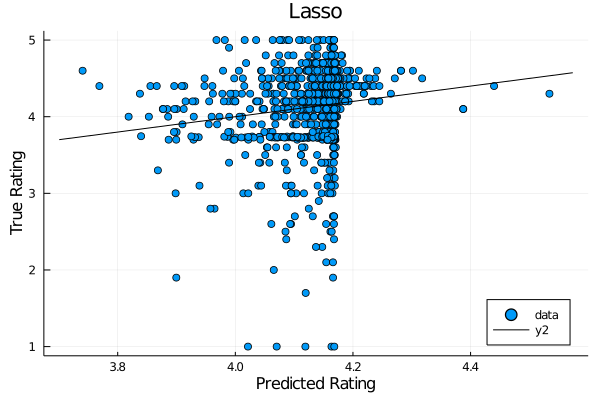

In [233]:
lasso = Lasso()
lasso.fit(train_vals, train_y)

train_pred = lasso.predict(train_vals);
test_pred = lasso.predict(test_vals);

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)

println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

train_MAE = mean_absolute_error(train_y, train_pred)
test_MAE = mean_absolute_error(test_y, test_pred)
    
print("\n")
println("Train MAE\t", train_MAE)
println("Test MAE \t", test_MAE)

plot_pred_true(test_pred, test_y, "Lasso")

In [ ]:
en = ElasticNet()
en.fit(train_vals, train_y)

train_pred = en.predict(train_vals);
test_pred = en.predict(test_vals);

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)

println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

train_MAE = mean_absolute_error(train_y, train_pred)
test_MAE = mean_absolute_error(test_y, test_pred)
    
print("\n")
println("Train MAE\t", train_MAE)
println("Test MAE \t", test_MAE)

plot_pred_true(test_pred, test_y, "ElasticNet")

In [ ]:
kernels = ["rbf"]

for i=1:length(kernels)

    println("Type of kernel: ", kernels[i])
    svrModel = SVR(kernel=kernels[i])
    svrModel.fit(train_vals, train_y)

    train_pred = svrModel.predict(train_vals);
    test_pred = svrModel.predict(test_vals);

    train_MSE = MSE(train_y, train_pred)
    test_MSE = MSE(test_y, test_pred)

    println("Train MSE\t", train_MSE)
    println("Test MSE \t", test_MSE)

    train_MAE = mean_absolute_error(train_y, train_pred)
    test_MAE = mean_absolute_error(test_y, test_pred)

    print("\n")
    println("Train MAE\t", train_MAE)
    println("Test MAE \t", test_MAE)

    plot_pred_true(test_pred, test_y, "Support Vector Machine")
    
end

Train MSE	6.233284738656892e-8
Test MSE 	0.35787603628621933

Train MAE	1.0836702553415901e-5
Test MAE 	0.36961746761601355


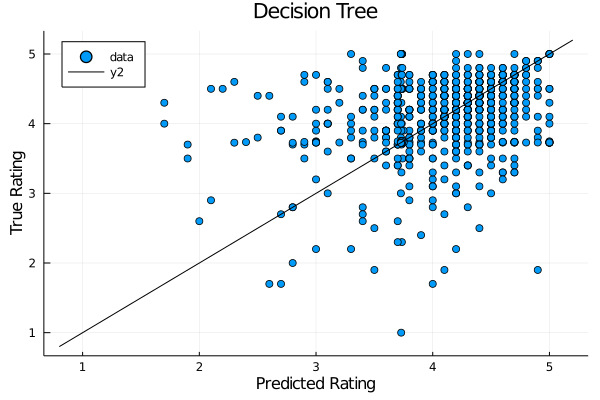

In [513]:
dt = DecisionTreeRegressor()
dt.fit(train_vals, train_y)

train_pred = dt.predict(train_vals);
test_pred = dt.predict(test_vals);

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)

println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

train_MAE = mean_absolute_error(train_y, train_pred)
test_MAE = mean_absolute_error(test_y, test_pred)
    
print("\n")
println("Train MAE\t", train_MAE)
println("Test MAE \t", test_MAE)

plot_pred_true(test_pred, test_y, "Decision Tree")

In [562]:
for i=1:10
    
    println("Max depth: ", i)
    dt = DecisionTreeRegressor(max_depth=i, random_state=1)
    dt.fit(train_vals, train_y)

    train_pred = dt.predict(train_vals);
    test_pred = dt.predict(test_vals);

    train_MSE = MSE(train_y, train_pred)
    test_MSE = MSE(test_y, test_pred)

    println("Train MSE\t", train_MSE)
    println("Test MSE \t", test_MSE)
    print("\n")

end

Max depth: 1
Train MSE	0.23318748183676147
Test MSE 	0.22219193808261764

Max depth: 2
Train MSE	0.2259565993151222
Test MSE 	0.21474971061895512

Max depth: 3
Train MSE	0.2221861556988116
Test MSE 	0.21364351761412526

Max depth: 4
Train MSE	0.2171579998694553
Test MSE 	0.2105002605953448

Max depth: 5
Train MSE	0.21180894407339504
Test MSE 	0.20583436747898615

Max depth: 6
Train MSE	0.20612557101038392
Test MSE 	0.20910264762312394

Max depth: 7
Train MSE	0.1989114599422564
Test MSE 	0.20886784236848757

Max depth: 8
Train MSE	0.19231468078718497
Test MSE 	0.2126886702335017

Max depth: 9
Train MSE	0.18345205573936402
Test MSE 	0.21685747825766225

Max depth: 10
Train MSE	0.1736385133552819
Test MSE 	0.22607171559291883



In [563]:
dt = DecisionTreeRegressor(max_depth=7)
@time begin
dt.fit(train_vals, train_y)
end

train_pred = dt.predict(train_vals);
test_pred = dt.predict(test_vals);

println(minimum(test_pred))
println(maximum(test_pred))

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)

println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)
print("\n")

plot_pred_true(test_pred, test_y, "Decision Tree Max-Depth=7")
png("DecisionTree")
# println(minimum(test_pred))
# println(maximum(test_pred))
# println(sizeof(train_vals))

  0.033148 seconds (17 allocations: 976 bytes)
2.7999999999999994
4.7
Train MSE	0.1989114599422564
Test MSE 	0.20944060854363458



In [564]:
print((dt.feature_importances_))
print(length(dt.feature_importances_))

[0.0021238214390772296, 0.005242246359739166, 0.0, 0.0005631033667297757, 0.0, 0.0, 0.0, 0.0, 0.0, 0.013547210641680643, 0.0, 0.0, 0.0, 8.396451094266506e-5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0020470793992681973, 0.0005373728700329648, 0.0, 0.003758748050390956, 0.0, 0.0015976963188375555, 0.0, 0.0, 0.0, 0.0, 0.0018857826080604374, 0.0, 0.0014209293707657345, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002380158318962881, 0.0, 0.0, 0.0, 0.0, 0.0, 0.008217977691644588, 0.0, 0.0, 0.0, 2.1732328336363413e-6, 0.015011593003441213, 9.383139334022391e-7, 0.0, 0.011631286223228326, 0.0022159789629390856, 0.0, 0.0, 0.0, 0.0, 0.0016823929798137707, 0.019657717677160364, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.007331160297505031, 0.0, 0.0, 0.0010418456079368203, 0.0, 0.0, 0.0, 0.0, 0.0, 0.007512431742612455, 0.005271370580533438, 0.006522989887956026, 0.0023884990275202284, 0.005332909002570979, 0.010917739844038927, 0.0, 0.0, 0.6402487332349857, 0.10084530228353951, 

In [565]:
print(size(train_vals, 2))

100

In [566]:
nonzero = 0
for i = 1:size(dt.feature_importances_, 1)
    if dt.feature_importances_[i] != 0
        nonzero += 1 
    end
end

print(nonzero)

33

In [567]:
println(maximum(dt.feature_importances_))
println(minimum(dt.feature_importances_))
println(mean(dt.feature_importances_))

0.6402487332349857
0.0
0.01


In [568]:
sfm = SelectFromModel(dt, threshold=0.005)
sfm.fit(train_vals, train_y)
train_transformed = sfm.transform(train_vals) 
test_transformed = sfm.transform(test_vals)

println("Shape of the dataset ", size(train_transformed))

@time begin
dt.fit(train_transformed, train_y)
end

train_pred = dt.predict(train_transformed);
test_pred = dt.predict(test_transformed);

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)

println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)
print("\n")

plot_pred_true(test_pred, test_y, "Reduced Decision Tree Max-Depth=7");
png("DecisionTreeTransformed")

println(minimum(test_pred))
println(maximum(test_pred))
# println(sizeof(train_transformed))

Shape of the dataset (8671, 16)
  0.013260 seconds (17 allocations: 976 bytes)
Train MSE	0.19907457495164238
Test MSE 	0.2095460015523212

2.7999999999999994
4.685560922907045


In [ ]:
train_vals_update_rev = hcat(train_vals_update, train_vals_rev)
test_vals_update_rev = hcat(test_vals_update, test_vals_rev)

dt = DecisionTreeRegressor(max_depth=5)
dt.fit(train_vals_update_rev, train_y)

train_pred = dt.predict(train_vals_update_rev);
test_pred = dt.predict(test_vals_update_rev);

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)

println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

train_MAE = mean_absolute_error(train_y, train_pred)
test_MAE = mean_absolute_error(test_y, test_pred)
    
print("\n")
println("Train MAE\t", train_MAE)
println("Test MAE \t", test_MAE)

plot_pred_true(test_pred, test_y, "Decision Tree")

Train MSE	0.027810973326960323
Test MSE 	0.18558379695583202

Train MAE	0.10706057199319849
Test MAE 	0.2792466720457038


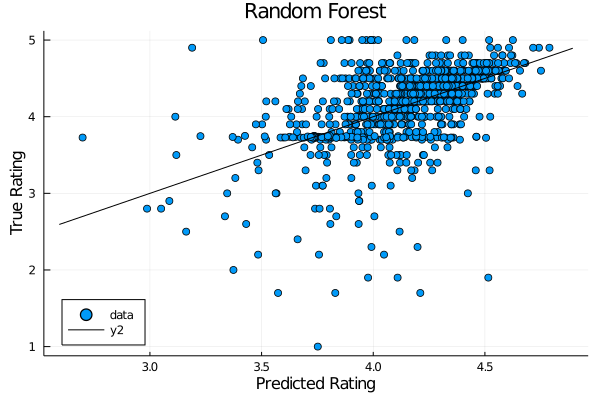

In [569]:
rf = RandomForestRegressor()
rf.fit(train_vals, train_y)

train_pred = rf.predict(train_vals);
test_pred = rf.predict(test_vals);

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)

println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

train_MAE = mean_absolute_error(train_y, train_pred)
test_MAE = mean_absolute_error(test_y, test_pred)
    
print("\n")
println("Train MAE\t", train_MAE)
println("Test MAE \t", test_MAE)

plot_pred_true(test_pred, test_y, "Random Forest")

**Note:** Random Forest Regression has the lowest training error thus far, but there is overfitting occuring. Can we reduce the number of features? 

In [ ]:
features_train = [train_vals_cat, train_vals_rev, train_vals_size, train_vals_installs, train_vals_type, train_vals_cr, 
    train_vals_genre, train_vals_update]

features_test = [test_vals_cat, test_vals_rev, test_vals_size, test_vals_installs, test_vals_type, test_vals_cr, 
    test_vals_genre, test_vals_update]

features = ["Category", "Reviews", "Size", "Installs", "Type", "ContentRating", "Genre", "LastUpdate"]

for i=1:length(features_train)
    
    println(features[i])
    
    rf = RandomForestRegressor()
    rf.fit(features_train[i], train_y)
    
    train_pred = rf.predict(features_train[i]);
    test_pred = rf.predict(features_test[i]);

    train_MSE = MSE(train_y, train_pred)
    test_MSE = MSE(test_y, test_pred)

    println("Train MSE\t", train_MSE)
    println("Test MSE \t", test_MSE)

#     train_MAE = mean_absolute_error(train_y, train_pred)
#     test_MAE = mean_absolute_error(test_y, test_pred)
    
#     println("Train MAE\t", train_MAE)
#     println("Test MAE \t", test_MAE)
    print("\n")
       
end


**Note:** Overfitting still occurs even when reducing feature count. Let's try early stopping, i.e. changing the max depth, rather than reaching pure leaves.

In [570]:
for i=1:10
    
    println("Max depth: ", i)
    rf = RandomForestRegressor(max_depth=i, random_state=1)
    rf.fit(train_vals, train_y)

    train_pred = rf.predict(train_vals);
    test_pred = rf.predict(test_vals);

    train_MSE = MSE(train_y, train_pred)
    test_MSE = MSE(test_y, test_pred)

    println("Train MSE\t", train_MSE)
    println("Test MSE \t", test_MSE)

#     train_MAE = mean_absolute_error(train_y, train_pred)
#     test_MAE = mean_absolute_error(test_y, test_pred)
    
#     println("Train MAE\t", train_MAE)
#     println("Test MAE \t", test_MAE)

    print("\n")

#     plot_pred_true(test_pred, test_y, "Random Forest")
end

Max depth: 1
Train MSE	0.2317590502211862
Test MSE 	0.22064604612892458

Max depth: 2
Train MSE	0.22478362128585788
Test MSE 	0.21326996355620684

Max depth: 3
Train MSE	0.2188413882429461
Test MSE 	0.20913507134093354

Max depth: 4
Train MSE	0.2128779260637624
Test MSE 	0.2053944775480943

Max depth: 5
Train MSE	0.20583870364206824
Test MSE 	0.2015843803884502

Max depth: 6
Train MSE	0.19771807643487185
Test MSE 	0.19822057631893014

Max depth: 7
Train MSE	0.1882567947850865
Test MSE 	0.19630743294320663

Max depth: 8
Train MSE	0.17751570099563665
Test MSE 	0.19446003547465823

Max depth: 9
Train MSE	0.16579700755999902
Test MSE 	0.1924190179159135

Max depth: 10
Train MSE	0.15332357628026547
Test MSE 	0.19052419097625262



**Conclusion:** Max depth of 5 performs best

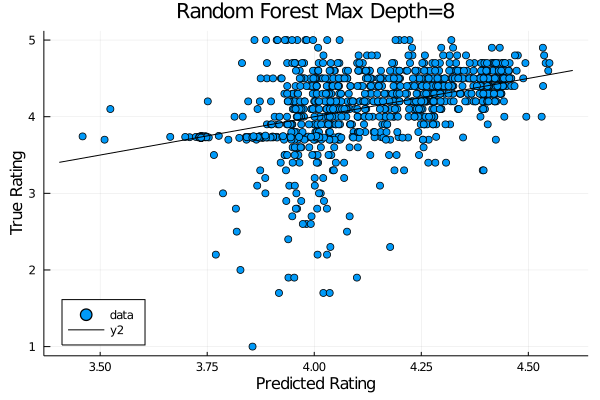

In [571]:
rf = RandomForestRegressor(max_depth=7, random_state=1)
rf.fit(train_vals, train_y)

train_pred = rf.predict(train_vals);
test_pred = rf.predict(test_vals);

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)

plot_pred_true(test_pred, test_y, "Random Forest Max Depth=7")
# png("RandomForest")

In [574]:
plot_pred_true(test_pred, test_y, "Random Forest Max Depth=7")
png("RandomForest")
print(test_MSE)

0.19630743294320663

In [575]:
println(maximum(test_pred))
println(minimum(test_pred))
println(mean(test_pred))

4.551643458576573
2.740830493546651
4.127914157029739


In [576]:
println(maximum(rf.feature_importances_))
println(minimum(rf.feature_importances_))
println(mean(rf.feature_importances_))

0.5760871491010947
0.0
0.01


In [577]:
print(rf.feature_importances_)

[0.0012459447125252629, 0.0032362381707014432, 0.0007822766606879762, 0.001188899774007673, 0.0008587698844137759, 0.005279741560077951, 0.00010846599286614164, 0.0008227045190370134, 0.0014709371269617003, 0.01671093905253068, 0.00032608626168418724, 0.0005966471043146076, 5.560467767226062e-5, 0.0020160565023557234, 0.00636976182207642, 0.0010696131804761974, 0.00040741501095852424, 9.78774582511387e-6, 0.0005338307862998279, 0.0009253222003859885, 0.0012322115094061453, 0.0037275924942315472, 0.004644658964626671, 7.489745499163329e-5, 0.0014301116945855561, 3.690820721335921e-5, 0.0010202654944263193, 0.00046276375626917146, 0.0009329447029489969, 0.00044959123800763844, 0.0, 0.0010016255761016227, 0.0013232116918128962, 0.000138996655686995, 0.0004418701189661008, 0.00021753375437071827, 0.0025103971066619455, 0.0019316658666574031, 0.0003650492801340908, 0.0004664230213574227, 0.0002269443979854484, 8.207425705838861e-5, 0.00011177241834135941, 0.00010963262675417633, 1.425668592

In [578]:
sfm = SelectFromModel(rf, threshold=0.001)
sfm.fit(train_vals, train_y)
train_transformed = sfm.transform(train_vals) 
test_transformed = sfm.transform(test_vals)

println("Shape of the dataset ", size(train_transformed))

@time begin
rf.fit(train_transformed, train_y)
end

train_pred = rf.predict(train_transformed);
test_pred = rf.predict(test_transformed);

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)

println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)
print("\n")

plot_pred_true(test_pred, test_y, "Reduced Random Forest Max-Depth=5")
# png("DecisionTreeTransformed")

println(minimum(test_pred))
println(maximum(test_pred))
println(sizeof(train_transformed))

Shape of the dataset (8671, 48)
  1.368393 seconds (17 allocations: 976 bytes)
Train MSE	0.18808850065069818
Test MSE 	0.19667381703813025

2.716198450120349
4.5580351562639345
3329664
